# dis-cover debian packages analysis

I ran a script on a 16-core machine during the weekend to analyze all debian packages that have **libgcc1** as a dependency.

Almost 24h of computation later, here is a second analysis of the results !

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import requests
from dis_cover.analysis import CppClass

In [2]:
data = pickle.load(open("analysis.2.pickle", "rb"))
source = pickle.load(open("source.pickle", "rb"))

In [3]:
total_classes = 0
packages_where_class = 0
unique_classes = set()
classes_in_packages = []
distribution = {}
no_rtti_but_classes = 0
no_flag_no_classes = 0

In [4]:
print("The total number of packages that have libgcc1 as a dependency is %d." % len(data))

The total number of packages that have libgcc1 as a dependency is 5827.


In [5]:
print("The algorithm that extracted this data focused on binaries in four directories : \n- usr/bin\n- usr/sbin\n- usr/lib\n- usr/games\n")
print("There are a few malformed packages we are not able to analyze.")
for package in data:
    files = data[package]
    classes_in_this_package = set()
    classes = 0
    for file in files:
        if file in ["failed", "no_file_found", "could_not_extract"]:
            print("%17s : %s" % (file, package))
            continue
        total_classes += len(data[package][file])
        for c in data[package][file]:
            if c in classes_in_this_package:
                continue
            classes_in_this_package.add(c)
            unique_classes.add(c)
            classes += 1
    classes_in_packages.append((package, classes))

    if distribution.get(classes) == None:
        distribution[classes] = 1
    else:
        distribution[classes] += 1

    if classes > 0:
        packages_where_class += 1
        if len(source[package]):
            no_rtti_but_classes += 1
    else:
        if not len(source[package]):
            no_flag_no_classes += 1

The algorithm that extracted this data focused on binaries in four directories : 
- usr/bin
- usr/sbin
- usr/lib
- usr/games

There are a few malformed packages we are not able to analyze.
    no_file_found : zutils
    no_file_found : libpam-biometric
    no_file_found : pcp-testsuite
could_not_extract : patchage
    no_file_found : libnutclient0
could_not_extract : memlockd
    no_file_found : libnss-libvirt
could_not_extract : libfolia9
could_not_extract : libbuffy-perl
could_not_extract : iptstate
    no_file_found : gdisk
    no_file_found : collectd
could_not_extract : libarpack2
    no_file_found : apcupsd


In [6]:
print("The number of packages where we were able to extract classes is %d out of %d (%d%%)." % (
    packages_where_class,
    len(data),
    packages_where_class / (len(data) or 1) * 100,
))

print("The total number of classes found is %d, and of those, %d%% were unique across all packages." % (
    total_classes,
    round(100 * len(unique_classes) / total_classes)
))

print(
    "The mean number of unique classes in packages where there are classes is %d." % (total_classes / (packages_where_class or 1)),
)

The number of packages where we were able to extract classes is 3194 out of 5827 (54%).
The total number of classes found is 960188, and of those, 39% were unique across all packages.
The mean number of unique classes in packages where there are classes is 300.


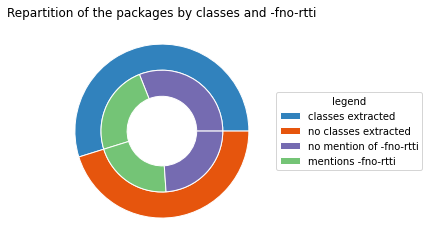

A "Mention" of `-fno-rtti` means that there were results when running a global grep for `-fno-rtti` in the package's source code
Usually, we see that in a same project, two binaries can be compiled with different flags, which leads to this result.


In [7]:
fig, ax = plt.subplots()

size = 0.3
vals = np.array([
    [packages_where_class - no_rtti_but_classes, no_rtti_but_classes],
    [len(source) - packages_where_class - no_flag_no_classes, no_flag_no_classes]
])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([12, 9, 9, 12])

wedges, texts = ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

wedges2, texts2 = ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Repartition of the packages by classes and -fno-rtti')

ax.legend(wedges + wedges2,
          [
              'classes extracted',
              'no classes extracted',
              'no mention of -fno-rtti',
              'mentions -fno-rtti',
          ],
          title="legend",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()
print("A \"Mention\" of `-fno-rtti` means that there were results when running a global grep for `-fno-rtti` in the package's source code")
print("Usually, we see that in a same project, two binaries can be compiled with different flags, which leads to this result.")

In [8]:
classes_in_packages.sort(key=lambda p: p[1], reverse=True)
n = 20
print("Top %d packages by number of unique classes:" % n)
for (p, c) in classes_in_packages[:n]:
    print(" - %s has %d classes" % (p ,c))

Top 20 packages by number of unique classes:
 - insighttoolkit4-python has 32801 classes
 - libsimpleitk1.0 has 20385 classes
 - bagel has 19843 classes
 - libreoffice-core has 8259 classes
 - mlpack-bin has 6377 classes
 - scummvm has 5931 classes
 - clickhouse-tools has 5360 classes
 - freeorion has 5230 classes
 - freefem++ has 4116 classes
 - itksnap has 3866 classes
 - ceph-test has 3372 classes
 - libreoffice-calc has 3080 classes
 - qtcreator has 2992 classes
 - lldb-7 has 2986 classes
 - godot3 has 2877 classes
 - libreoffice-writer has 2873 classes
 - liblldb-7 has 2851 classes
 - ecflow-client has 2841 classes
 - godot3-server has 2804 classes
 - caffe-tools-cpu has 2772 classes


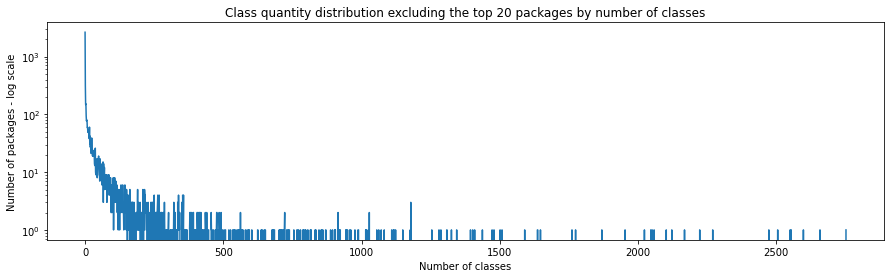

In [9]:
x = range(classes_in_packages[20][1] + 1)
y = [distribution.get(v) or 0 for v in x]
plt.figure(figsize=(15,4))
plt.plot(x, y)
plt.yscale('log')
plt.title("Class quantity distribution excluding the top 20 packages by number of classes")
plt.xlabel("Number of classes")
plt.ylabel("Number of packages - log scale")
plt.show()

## By popularity

We now use data from [popcon](https://popcon.debian.org), the official debian popularity contest, in order to sort and isolate packages by **installation** and **usage**.

In [10]:
res = requests.get("https://popcon.debian.org/by_inst")
popularity = res.text

In [11]:
classes_dict = dict(classes_in_packages)

In [12]:
packages_with_votes = []
for line in popularity.split("\n")[:-3]:
    if line[0] == "#":
        continue
    (name, inst, vote) = line.split()[1:4]
    classes = classes_dict.get(name)
    if classes != None:
        packages_with_votes.append((name, int(inst), int(vote), classes))

In [13]:
by_inst = sorted(packages_with_votes, key=lambda x: x[1], reverse=True)
by_vote = sorted(packages_with_votes, key=lambda x: x[2], reverse=True)

def print_stats(sorted_list, n):
    mean = 0
    no_classes = 0
    filtered_list = sorted_list[:n]
    for v in filtered_list:
        mean += v[-1]
        if v[-1] == 0:
            no_classes += 1
    mean /= n
    print("There are %d packages with no classes (either -fno-rtti or no virtual methods)." % no_classes)
    print("There is a mean of %d unique classes per package" % mean)

n = 100
print("In the top %d C++ packages, sorted by installations:" % n)
print_stats(by_inst, n)
print()
print("In the top %d C++ packages, sorted by usage:" % n)
print_stats(by_vote, n)

n = 1000
print()
print("In the top %d C++ packages, sorted by installations:" % n)
print_stats(by_inst, n)
print()
print("In the top %d C++ packages, sorted by usage:" % n)
print_stats(by_vote, n)

In the top 100 C++ packages, sorted by installations:
There are 39 packages with no classes (either -fno-rtti or no virtual methods).
There is a mean of 217 unique classes per package

In the top 100 C++ packages, sorted by usage:
There are 29 packages with no classes (either -fno-rtti or no virtual methods).
There is a mean of 234 unique classes per package

In the top 1000 C++ packages, sorted by installations:
There are 390 packages with no classes (either -fno-rtti or no virtual methods).
There is a mean of 103 unique classes per package

In the top 1000 C++ packages, sorted by usage:
There are 360 packages with no classes (either -fno-rtti or no virtual methods).
There is a mean of 110 unique classes per package


## Conclusion

Overall, this analysis is quite positive for the project : Around **40%** of **regularly used and installed C++ packages** have RTTI info we can extract, and the quantity of classes we can recover is not negligeable !